<a href="https://colab.research.google.com/github/iamfaham/stock-data-linear-regression/blob/main/stock_data_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install yfinance

In [2]:
import yfinance as yf
import pandas as pd

# Define the ticker symbol and the date range
ticker_symbol = "AAPL"  # Example: Apple Inc.
start_date = "2020-01-01"
end_date = "2025-07-01" # Data up to June 30th, 2025

# Download the data
stock_data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Display the first few rows of the data
display(stock_data.head())

/tmp/ipython-input-931646639.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker_symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.620827,72.681274,71.373203,71.627077,135480400
2020-01-03,71.914810,72.676439,71.689950,71.847110,146322800
2020-01-06,72.487869,72.526556,70.783271,71.034732,118387200
2020-01-07,72.146942,72.753823,71.926915,72.497529,108872000
2020-01-08,73.307510,73.609745,71.849533,71.849533,132079200


In [3]:
# Calculate moving averages
stock_data['SMA_20'] = stock_data['Close'].rolling(window=20).mean()
stock_data['SMA_50'] = stock_data['Close'].rolling(window=50).mean()

# Flatten the multi-level column index
stock_data.columns = stock_data.columns.get_level_values(0)

# Display the updated DataFrame with new features and flattened index
display(stock_data.head())

Price,Close,High,Low,Open,Volume,SMA_20,SMA_50
Date,,,,,,,
2020-01-02,72.620827,72.681274,71.373203,71.627077,135480400,NaN,NaN
2020-01-03,71.914810,72.676439,71.689950,71.847110,146322800,NaN,NaN
2020-01-06,72.487869,72.526556,70.783271,71.034732,118387200,NaN,NaN
2020-01-07,72.146942,72.753823,71.926915,72.497529,108872000,NaN,NaN
2020-01-08,73.307510,73.609745,71.849533,71.849533,132079200,NaN,NaN


In [4]:
import pandas as pd

# Assuming stock_data is already loaded and has the initial columns

# Calculate RSI
def calculate_rsi(data, window):
    delta = data.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

stock_data['RSI'] = calculate_rsi(stock_data['Close'], window=14)

# Calculate MACD
exp12 = stock_data['Close'].ewm(span=12, adjust=False).mean()
exp26 = stock_data['Close'].ewm(span=26, adjust=False).mean()
stock_data['MACD'] = exp12 - exp26
stock_data['MACD_Signal'] = stock_data['MACD'].ewm(span=9, adjust=False).mean()

# Calculate Bollinger Band component (20-day rolling standard deviation)
stock_data['BB_StdDev'] = stock_data['Close'].rolling(window=20).std()

# Calculate 20-day rolling average of Volume
stock_data['Volume_Avg'] = stock_data['Volume'].rolling(window=20).mean()

# Drop rows with NaN values created by moving averages and new features
stock_data.dropna(inplace=True)

# Display the updated DataFrame with new features and flattened index
display(stock_data.head())

Price,Close,High,Low,Open,Volume,SMA_20,SMA_50,RSI,MACD,MACD_Signal,BB_StdDev,Volume_Avg
Date,,,,,,,,,,,,
2020-03-13,67.369141,67.841748,61.305263,64.199059,370732000,70.923007,74.025907,45.068581,-2.653157,-2.030700,4.995096,243271420.0
2020-03-16,58.702312,62.790941,58.166693,58.639296,322423600,69.920358,73.747537,40.052927,-3.215642,-2.267688,5.340823,255386920.0
2020-03-17,61.283447,62.434659,57.778903,59.986813,324056000,69.118870,73.534910,41.593064,-3.413787,-2.496908,5.375664,263963160.0
2020-03-18,59.783234,60.590297,57.468684,58.110943,300233600,68.186385,73.280817,43.998914,-3.649800,-2.727486,5.291848,274275640.0
2020-03-19,59.325180,61.278611,58.799257,59.957743,271857200,67.271229,73.024382,43.661287,-3.829657,-2.947921,5.153898,282840200.0


In [5]:
from sklearn.model_selection import train_test_split
import pandas as pd # Import pandas to use Timestamp

# Define features (X) and target (y)
features = ['SMA_20', 'SMA_50', 'RSI', 'MACD', 'MACD_Signal', 'BB_StdDev', 'Volume_Avg']
target = 'Close'

X = stock_data[features]
y = stock_data[target]

# Split data based on date: train up to Jan 2025, test from Feb to Jun 2025
train_end_date = pd.Timestamp('2025-01-31')

X_train = X[X.index <= train_end_date]
y_train = y[y.index <= train_end_date]
X_test = X[X.index > train_end_date]
y_test = y[y.index > train_end_date]

# Print the shapes of the new sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)

Training set shape: (1229, 7) (1229,)
Testing set shape: (102, 7) (102,)


In [10]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Define and train Ridge Regression model with best parameters
best_params = {"alpha" : 1.0}
ridge_model = Ridge(**best_params)
print("Training Ridge Regression...")
ridge_model.fit(X_train, y_train)
print("Model training complete.\n")

# Make predictions and evaluate
y_pred_ridge = ridge_model.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

# Print evaluation metrics
print("Ridge Regression:")
print(f"Mean Squared Error (MSE): {mse_ridge:.4f}")
print(f"R-squared (R2) Score: {r2_ridge:.4f}\n")

Training Ridge Regression...
Model training complete.

Ridge Regression:
Mean Squared Error (MSE): 13.8651
R-squared (R2) Score: 0.9499



/usr/local/lib/python3.11/dist-packages/scipy/_lib/_util.py:1226: LinAlgWarning: Ill-conditioned matrix (rcond=2.85849e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


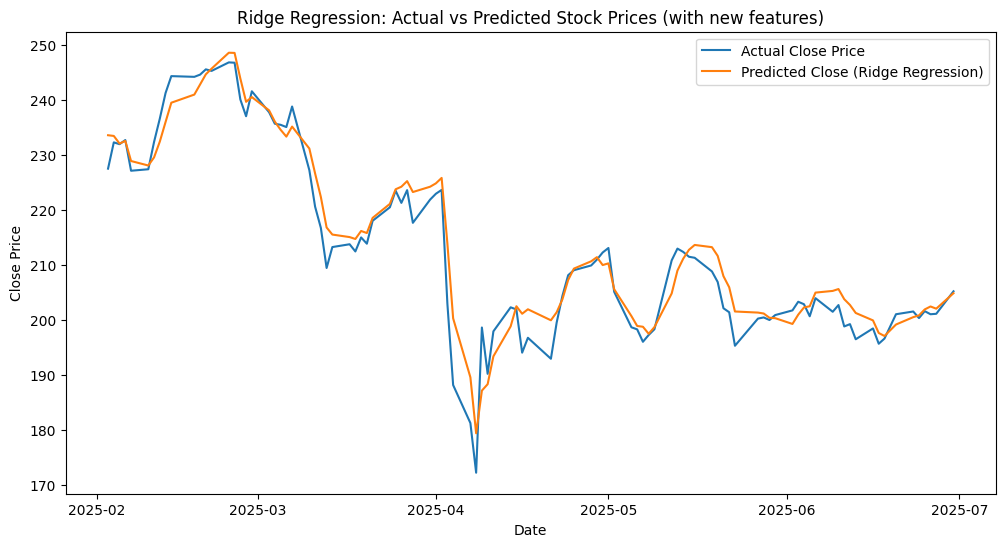

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming you have the trained ridge_model from previous steps
# And y_test, X_test are the test sets with the new features

# Make predictions on the test set
y_pred_ridge = ridge_model.predict(X_test)

# Create DataFrame for predictions
predictions_ridge_df = pd.DataFrame({'Actual Close': y_test.values.flatten(), 'Predicted Close (Ridge Regression)': y_pred_ridge.flatten()}, index=X_test.index)

# Plot actual vs predicted prices for Ridge Regression
plt.figure(figsize=(12, 6))
predictions_ridge_df_sorted = predictions_ridge_df.sort_index()
plt.plot(predictions_ridge_df_sorted.index, predictions_ridge_df_sorted['Actual Close'], label='Actual Close Price')
plt.plot(predictions_ridge_df_sorted.index, predictions_ridge_df_sorted['Predicted Close (Ridge Regression)'], label='Predicted Close (Ridge Regression)')
plt.title('Ridge Regression: Actual vs Predicted Stock Prices (with new features)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()